In [1]:
import os
import numpy as np
import pandas as pd
from tables import *
import h5py
import matplotlib.pyplot as plt
import seaborn as sns


### INTRODUCTION: in this Jupyter Notebook I will upload , preprocess and show histograms and spectograms

### Part 1. Start working with FILE data
### Part 2. Prepare functions
### Part 3. Part 3. Plotting data
### Part 4. Conclusion

## <div align="center">Part 1. Start working with FILE data</div>

###  PTNE Labels

#### Read CSV. Chage .wav to .hdf5

In [2]:
# specify YOUR PATH to the CSV file
csv_path=os.path.join('ESC50_Home','ESC-50-HumanClassification.csv')

# read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# check if all elements in the 'filename' column end with '.wav'
result = (df['filename'].str.endswith('.wav')).all()

# print the result
print(result)

# replace '.wav' with '.hdf5' in the 'filename' column
df['filename'] = df['filename'].str.replace('.wav', '.hdf5')

True


/var/folders/j7/x7b5nvcx4bg27rbk_51dbkgm0000gn/T/ipykernel_40435/580465781.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['filename'] = df['filename'].str.replace('.wav', '.hdf5')


#### Read categories from csv file

In [3]:
unique_categories = df['category'].unique()

# print the unique categories
print(unique_categories)

count_of_unique_categories = df['category'].nunique()
print(count_of_unique_categories)
print("")
print("Completed")

['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']
50

Completed


In [4]:
# list of categories taken from a blackboard
categories = [
    'Breathing',
    'Coughing',
    'Footsteps',
    'Laughing',
    'Sneezing',
    'Snoring',
    'Toilet_flush',
    'Vacuum_cleaner',
    'Washing_machine',
]

# change the capital letter to lowercase
categories = [category.lower() for category in categories]

# print the modified list
print(categories)
print("")
print("Completed")

%timeit

['breathing', 'coughing', 'footsteps', 'laughing', 'sneezing', 'snoring', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']

Completed


#### Make a dictionary with keys=categories and values=category_element

In [5]:
# Create empty dict for storing filenames for each category
filenames_by_category  = {}
number_of_files = 0

# iterate over the categories
for category in categories:
    # get all the filenames for the current category
    filenames = df.loc[df['category'].isin([category]), 'filename'].values.tolist()
    number_of_files += len(filenames)
    # create a key-value pair in the dictionary with the current category as the key and the list of filenames as the value
    filenames_by_category[category] = filenames

print("The number of files %f" %number_of_files)
print("Completed")

The number of files 360.000000
Completed


#### Make a dictionary with keys=categories and values=path_to_element

In [6]:
# Create empty dict for storing paths to files for each category
hdf5_paths_per_category = {}

# In order to control the flow of the code and not miss a change I keep trck on the number of files.
counter_files = 0
counter_categories = 0 

# Here you give a folder name where the files are stored.
# folder_name = "tracts"
folder_name = "ptne"


# iterate over the categories
for category in categories:
    counter_categories += 1
    
    # Create an empty list where I store paths for one type of category
    all_paths_for_same_category = list()
    
    # iterate over the list that belongs to exact category
    for i in filenames_by_category[category]:
        counter_files += 1
        
        # Create variable that store a single path
        # CHANGE TO YOUR PATH
        temp_hdf5_path=os.path.join('ESC50_Home', folder_name, i)
        
        # Store paths for one type of category in a list.
        # With the new category the list will be updated to 0
        all_paths_for_same_category.append(temp_hdf5_path)
        
    # Store a list according to the category
    hdf5_paths_per_category[category] = all_paths_for_same_category


print(type(hdf5_paths_per_category["snoring"]))
print(len(hdf5_paths_per_category["snoring"]))

print("The number of categories %f" %counter_categories)
print("The number of files %f" %counter_files)
print("Completed")

<class 'list'>
40
The number of categories 9.000000
The number of files 360.000000
Completed


In [7]:
#hdf5 files read in using h5py modules
the_file = h5py.File(hdf5_paths_per_category["snoring"][0], 'r')

# Print out
print("THDF5ract Labels: %s" % the_file.keys())

# Save Labels
hdf5_Labels  = list(the_file.keys()) # # Has 4 values inside


# Keys are listed out
print("HDF5 Labels: %s" % hdf5_Labels)


THDF5ract Labels: <KeysViewHDF5 ['energy', 'noise', 'pulse', 'tone']>
HDF5 Labels: ['energy', 'noise', 'pulse', 'tone']


In [8]:
tr_label_1 = hdf5_Labels[1]
tr_label_2 = hdf5_Labels[2]
tr_label_3 = hdf5_Labels[3]

print(tr_label_1)
print(tr_label_2)
print(tr_label_3)

noise
pulse
tone


## <div align="center">Part 2. Prepare functions</div>

### Store all the files of one category into the list

In [9]:
def create_arr_all_files_of_category(category_name, label_names):
    """ This code extracts data from hdf5 files, access the s_tract dataset in each file,  
    and append a portion of that data to a list called list_of_data"""
    
    counter_files = 0
    list_of_data = list() # Create list. Here we will store all arrays for 1 category
    
    # Get access to a file by iterating over the paths 
    for i in hdf5_paths_per_category[category_name]:
#         print(i)
        
        # By useing a path(i) we open hdf4 file in reading format(f).
        with h5py.File(i, 'r') as f:
#             print(f)
            
            # access the "s_tract" dataset in the file
            # s_tract has shape (100, 8497), class 'numpy.ndarray
            s_tract = f[label_names][()]
#             print(s_tract.shape)
            # Append a file and get rid of zeros in the bottom and in the top
            list_of_data.append(s_tract)
        
        counter_files += 1
        
#     print("Completed")
#     print(len(list_of_data))
    return list_of_data

### Functions for Spectograms and Histograms

In [10]:
def plot_spectrograms_log(input_arrays):
    num_arrays = len(input_arrays)
    fig, axes = plt.subplots(nrows=1, ncols=num_arrays, figsize=(8*num_arrays,3))

    for i, arr in enumerate(input_arrays):
        # Plot the spectrogram
        im = axes[i].imshow(np.log(arr), interpolation='nearest', aspect='auto', origin='lower', cmap='plasma')

        # Add labels and colorbar
        axes[i].set_title(hdf5_Labels[i])
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Frequency')
        
    cbar = fig.colorbar(im, ax=axes[i])
    cbar.set_label('Intensity')

    # Show the plot
    plt.show()


In [11]:
def plot_spectrograms(input_arrays):
    num_arrays = len(input_arrays)
    fig, axes = plt.subplots(nrows=1, ncols=num_arrays, figsize=(8*num_arrays,3))

    for i, arr in enumerate(input_arrays):
        # Plot the spectrogram
        im = axes[i].imshow(arr, interpolation='nearest', aspect='auto', origin='lower')

        # Add labels and colorbar
        axes[i].set_title(hdf5_Labels[i])
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Frequency')
        
    cbar = fig.colorbar(im, ax=axes[i])
    cbar.set_label('Intensity')

    # Show the plot
    plt.show()


In [13]:
def plot_histograms2(input_arrays):
    num_arrays = len(input_arrays)
    fig, axes = plt.subplots(nrows=1, ncols=num_arrays, figsize=(6*num_arrays,3))

    for i, arr in enumerate(input_arrays):
        # Plot the histogram
        # The important question is number of bins. Here the number of bins is random.
        axes[i].hist(arr, bins=8, color = 'blue', edgecolor = 'black')
        sns.histplot(arr, ax=axes[i])

        # Add labels
        axes[i].set_title(hdf5_Labels[i])
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    # Show the plot
    plt.show()


### Iterate over each label of hdf5 ptne in order to plot subplots

In [14]:
def category_4_label_hist(info_samples, category):
    data1D = list()
    for i in hdf5_Labels:        
        flat_sample = info_samples[category][i][5].flatten()
        data1D.append(flat_sample)
     
    plot_histograms2(data1D)

In [15]:
def category_4_labels(info_samples, category):
    sample_data_4 = list()
    for i in hdf5_Labels:
        sample_data_4.append(info_samples[category][i][5])
        
    plot_spectrograms(sample_data_4)
    plot_spectrograms_log(sample_data_4)

### Sorting out data and storing for the further plotting

In [16]:
# Save Labels for Each category

print(categories)
print(hdf5_Labels)
glagg = 0
print("")

info_samples = {}
# info_labels = {}

for i in categories:
    info_labels = {}
    for j in hdf5_Labels:
        info_labels[j] = create_arr_all_files_of_category(i, j)
        info_samples[i] = info_labels  
        glagg += 1
        
print(glagg)

['breathing', 'coughing', 'footsteps', 'laughing', 'sneezing', 'snoring', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']
['energy', 'noise', 'pulse', 'tone']

36


## <div align="center">Part 3. Plotting data</div>
## <div align="center">Histograms & Spectograms</div>

### <div align="center">breathing</div>

You are observing category:   breathing


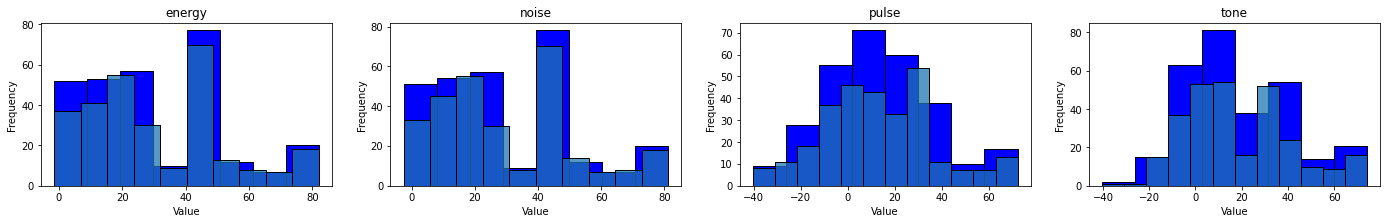

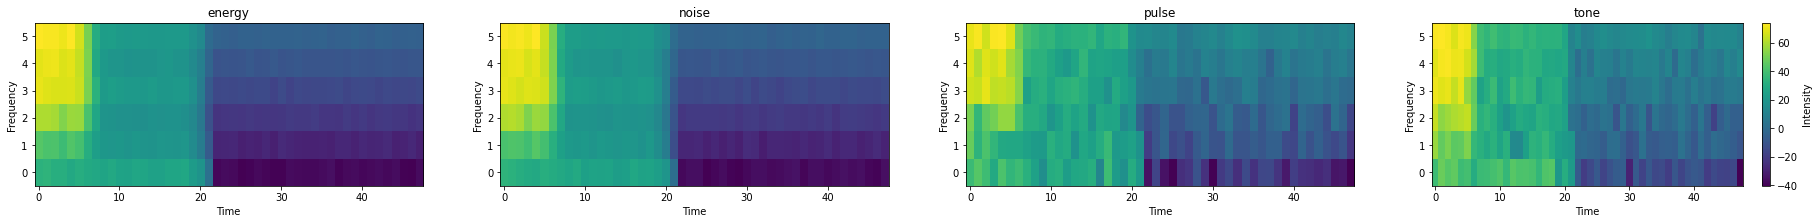

/var/folders/j7/x7b5nvcx4bg27rbk_51dbkgm0000gn/T/ipykernel_40435/1352259026.py:7: RuntimeWarning: invalid value encountered in log
  im = axes[i].imshow(np.log(arr), interpolation='nearest', aspect='auto', origin='lower', cmap='plasma')


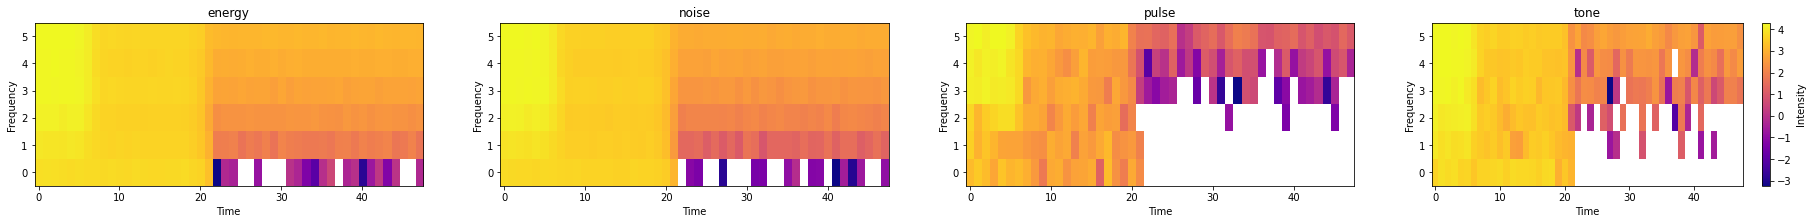

In [17]:
print("You are observing category:   %s" % categories[0])

category_4_label_hist(info_samples, categories[0])
print("")
category_4_labels(info_samples, categories[0])

### <div align="center">coughing</div>

You are observing category:   coughing


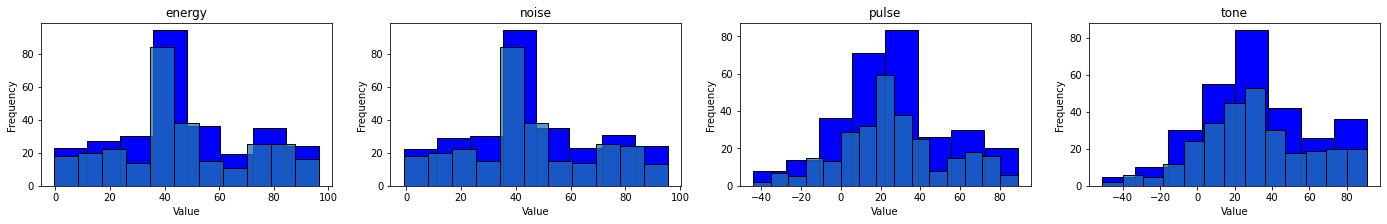

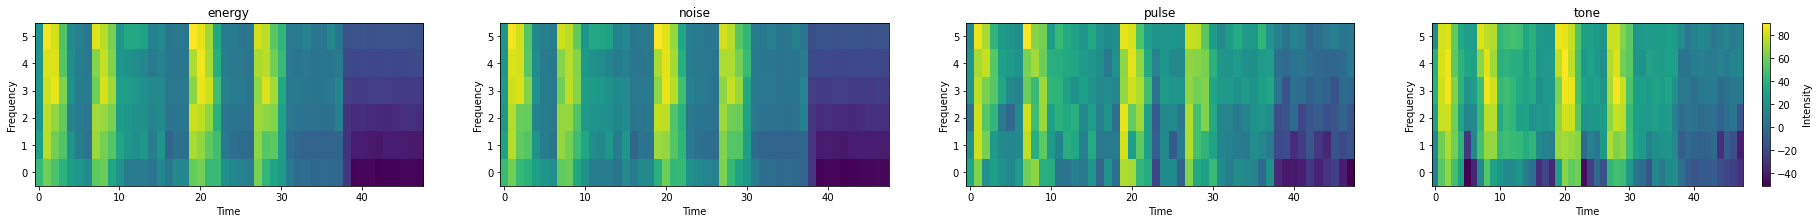

/var/folders/j7/x7b5nvcx4bg27rbk_51dbkgm0000gn/T/ipykernel_40435/1352259026.py:7: RuntimeWarning: invalid value encountered in log
  im = axes[i].imshow(np.log(arr), interpolation='nearest', aspect='auto', origin='lower', cmap='plasma')


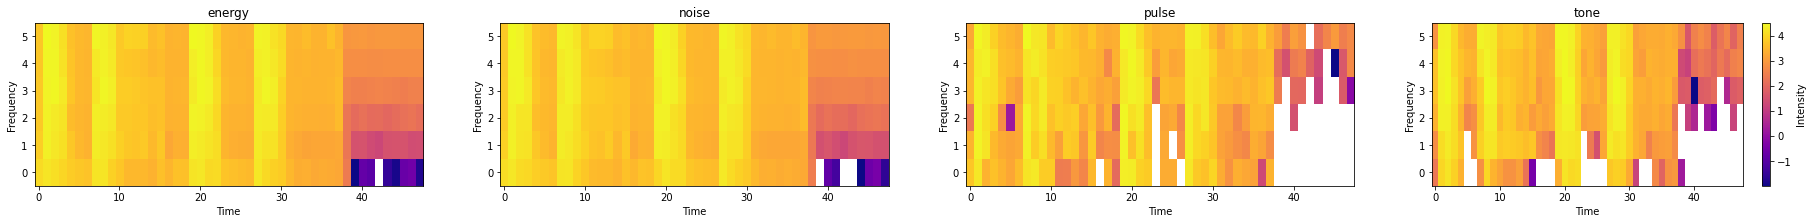

In [18]:
print("You are observing category:   %s" % categories[1])

category_4_label_hist(info_samples, categories[1])
print("")
category_4_labels(info_samples, categories[1])

### <div align="center">footsteps</div>

You are observing category:   footsteps


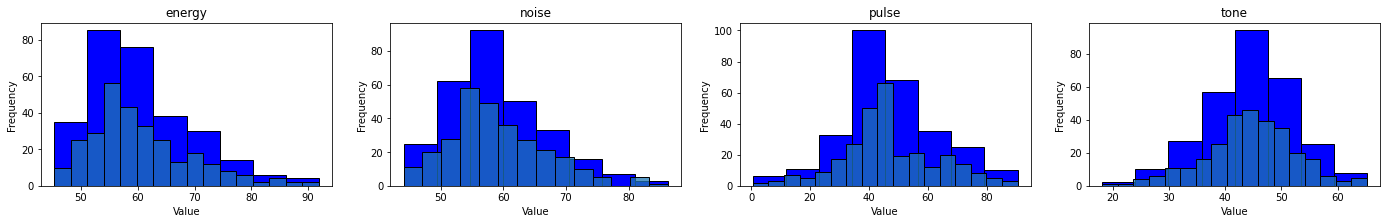

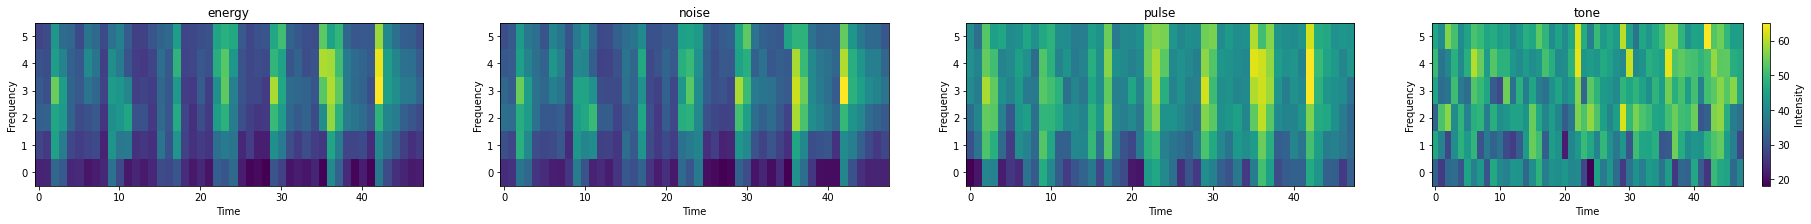

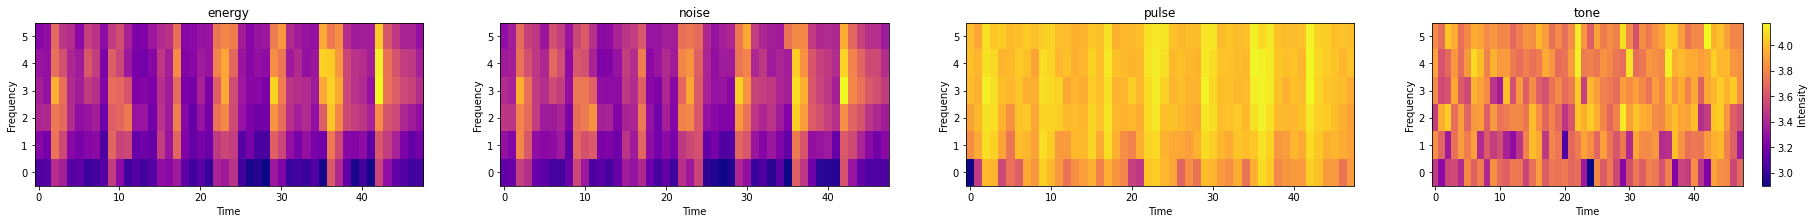

In [19]:
print("You are observing category:   %s" % categories[2])

category_4_label_hist(info_samples, categories[2])
print("")
category_4_labels(info_samples, categories[2])

### <div align="center">laughing</div>

You are observing category:   laughing


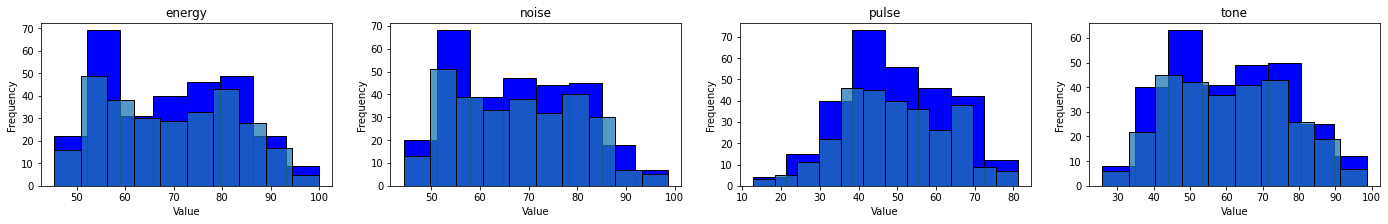

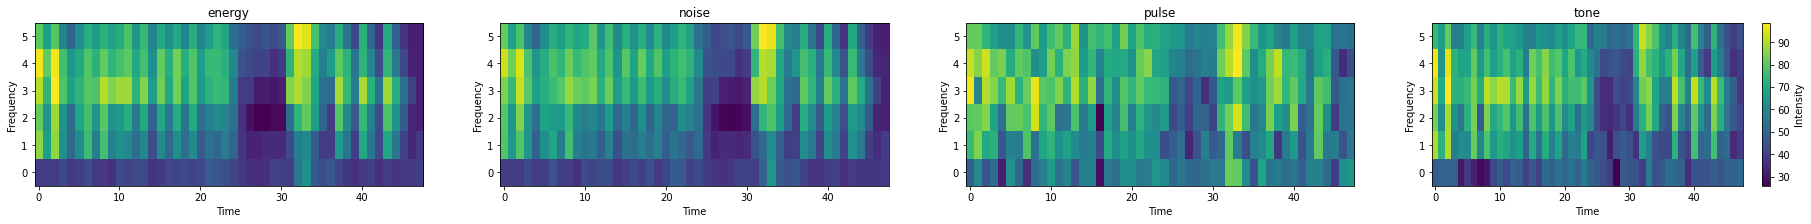

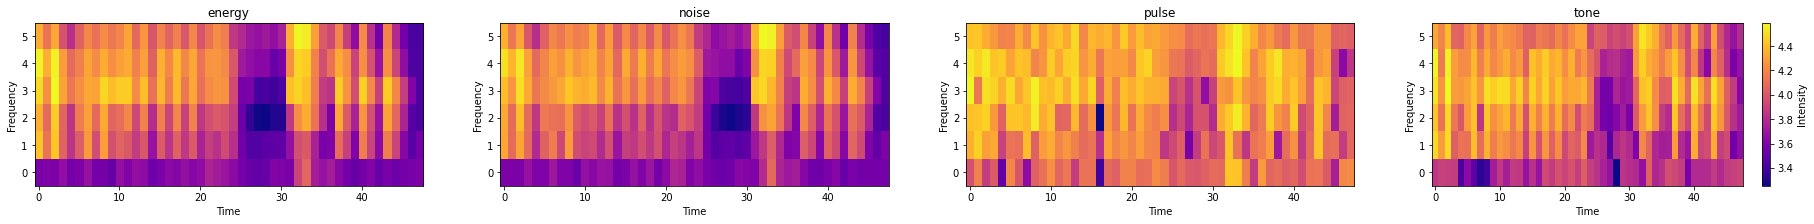

In [20]:
print("You are observing category:   %s" % categories[3])

category_4_label_hist(info_samples, categories[3])
print("")
category_4_labels(info_samples, categories[3])

### <div align="center">sneezing</div>

You are observing category:   sneezing


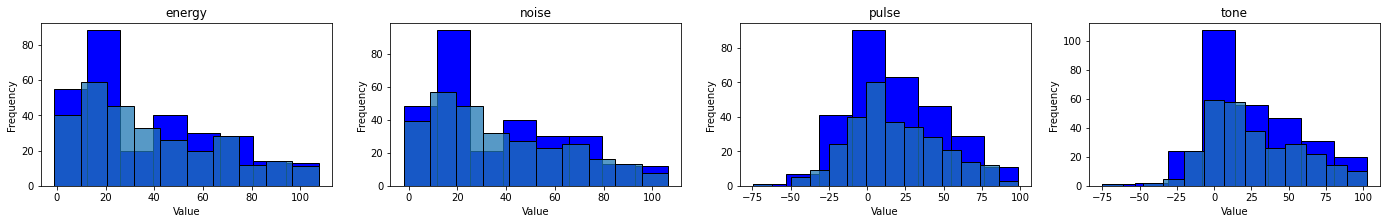

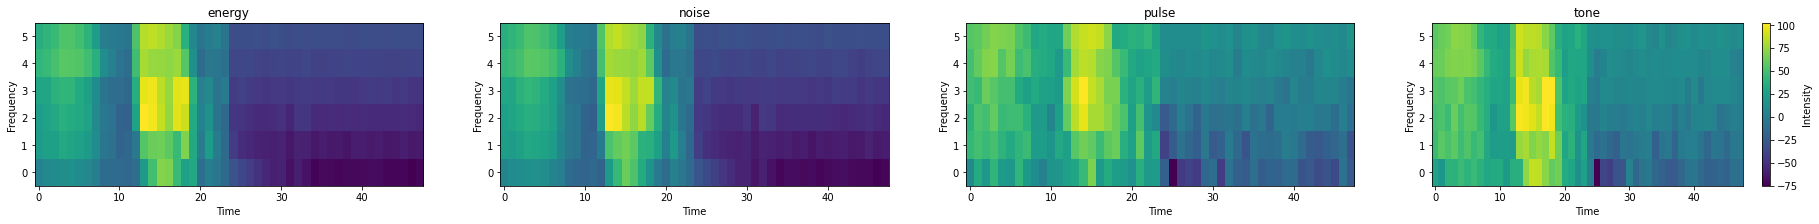

/var/folders/j7/x7b5nvcx4bg27rbk_51dbkgm0000gn/T/ipykernel_40435/1352259026.py:7: RuntimeWarning: invalid value encountered in log
  im = axes[i].imshow(np.log(arr), interpolation='nearest', aspect='auto', origin='lower', cmap='plasma')


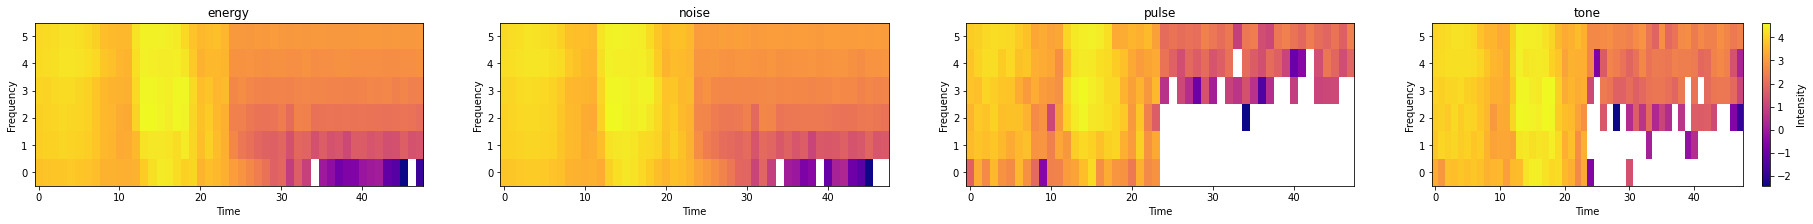

In [21]:
print("You are observing category:   %s" % categories[4])

category_4_label_hist(info_samples, categories[4])
print("")
category_4_labels(info_samples, categories[4])

### <div align="center">snoring</div>

You are observing category:   snoring


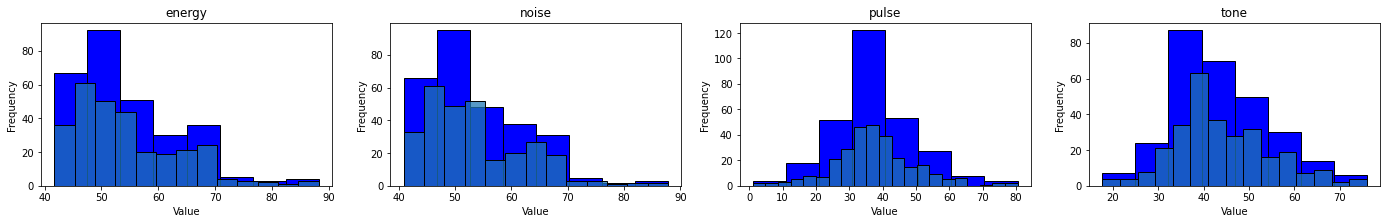

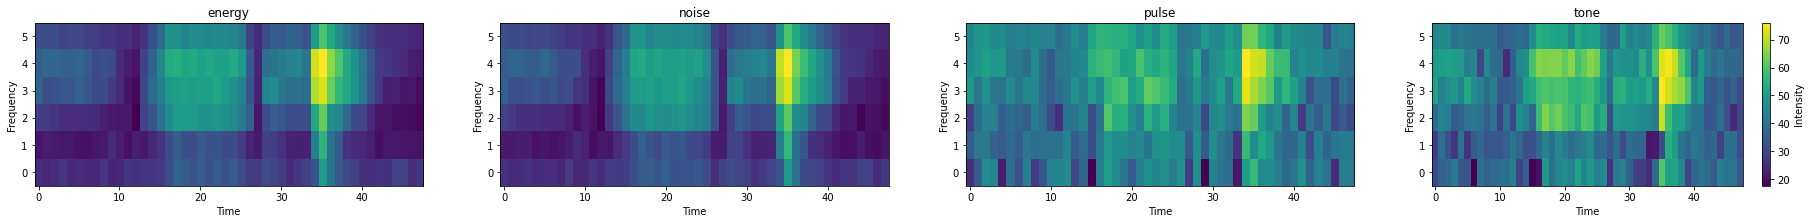

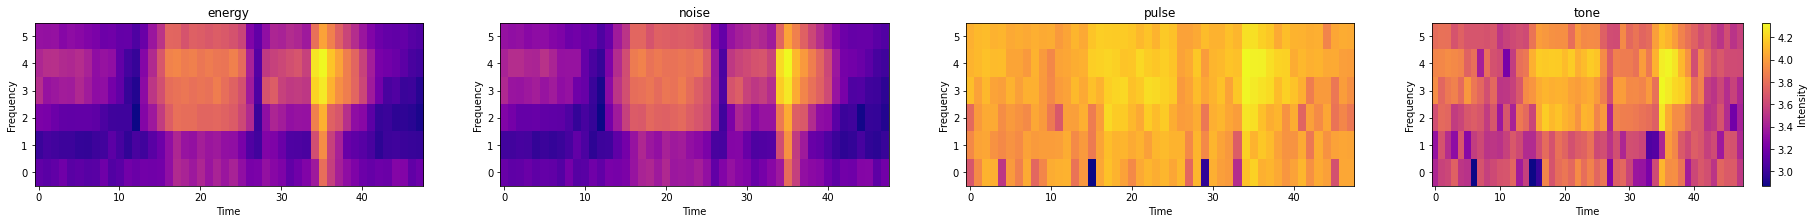

In [22]:
print("You are observing category:   %s" % categories[5])

category_4_label_hist(info_samples, categories[5])
print("")
category_4_labels(info_samples, categories[5])

### <div align="center">toilet flush</div>

You are observing category:   toilet_flush


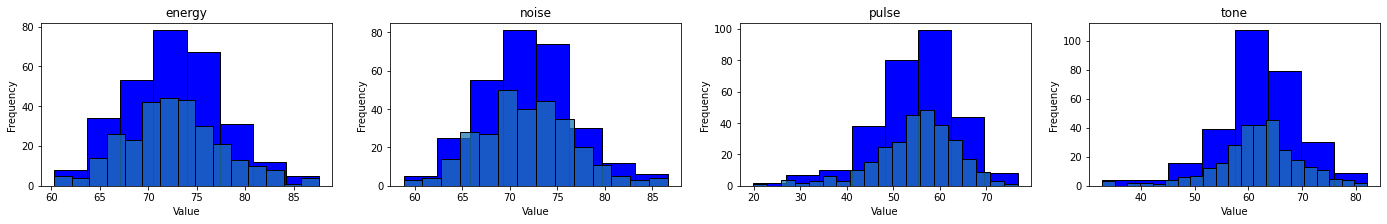

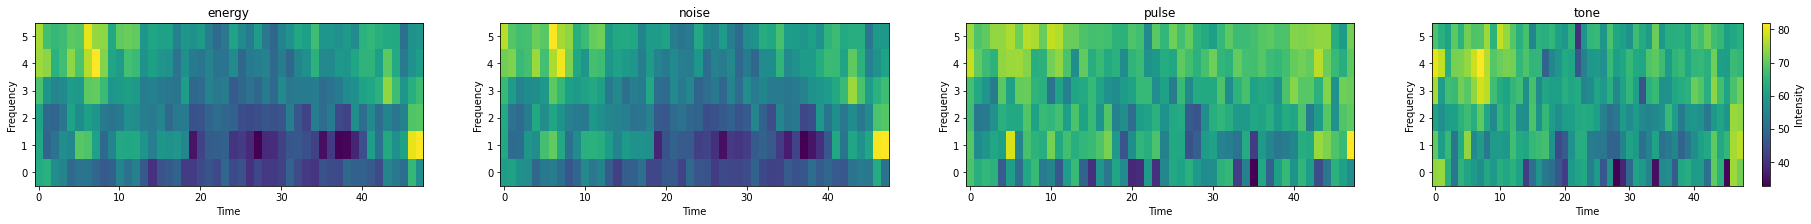

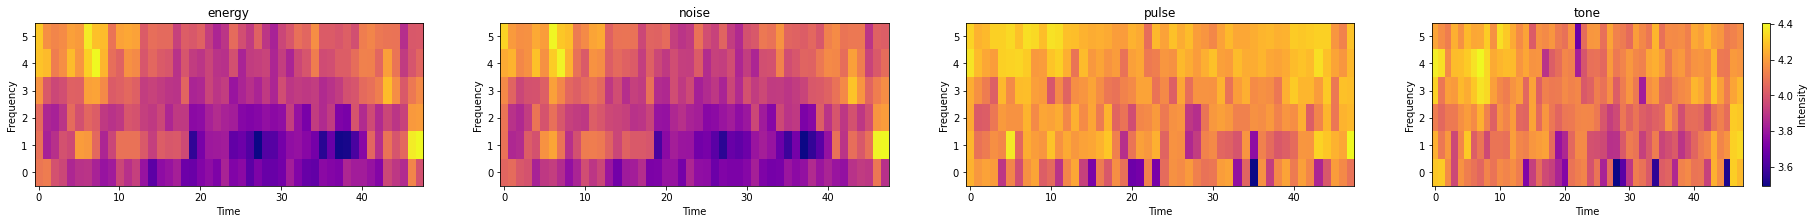

In [23]:
print("You are observing category:   %s" % categories[6])

category_4_label_hist(info_samples, categories[6])
print("")
category_4_labels(info_samples, categories[6])

### <div align="center">vacuum cleaner</div>

You are observing category:   vacuum_cleaner


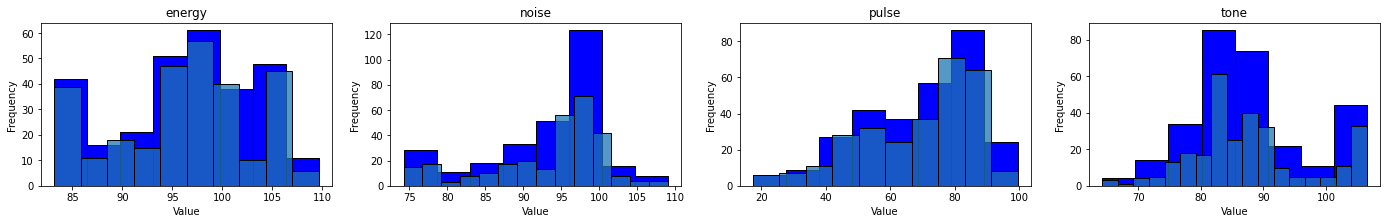

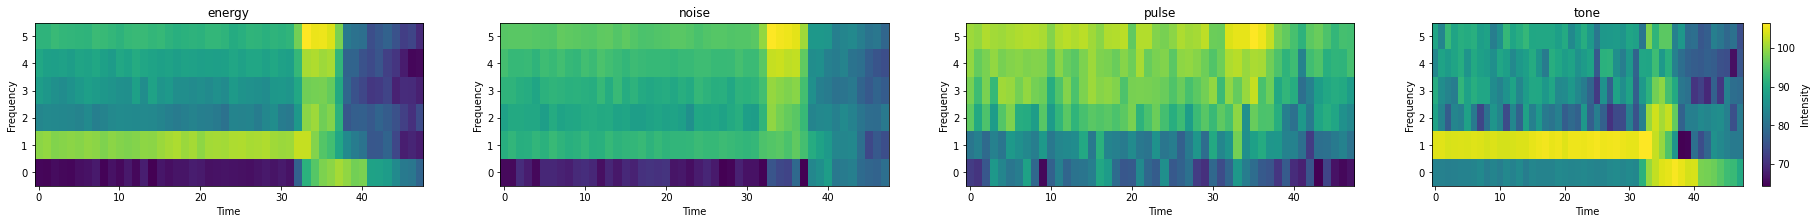

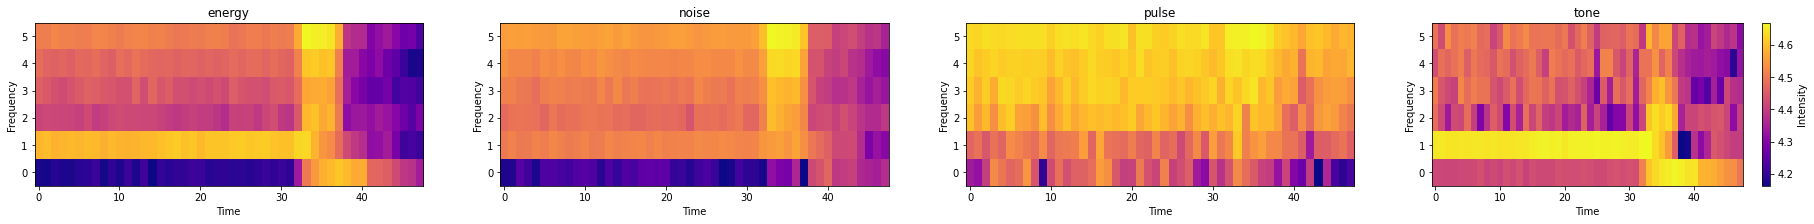

In [24]:
print("You are observing category:   %s" % categories[7])

category_4_label_hist(info_samples, categories[7])
print("")
category_4_labels(info_samples, categories[7])

### <div align="center">washing machine</div>

You are observing category:   washing_machine


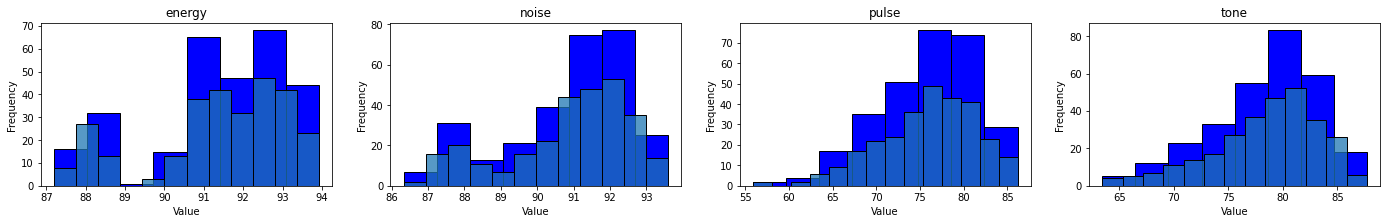

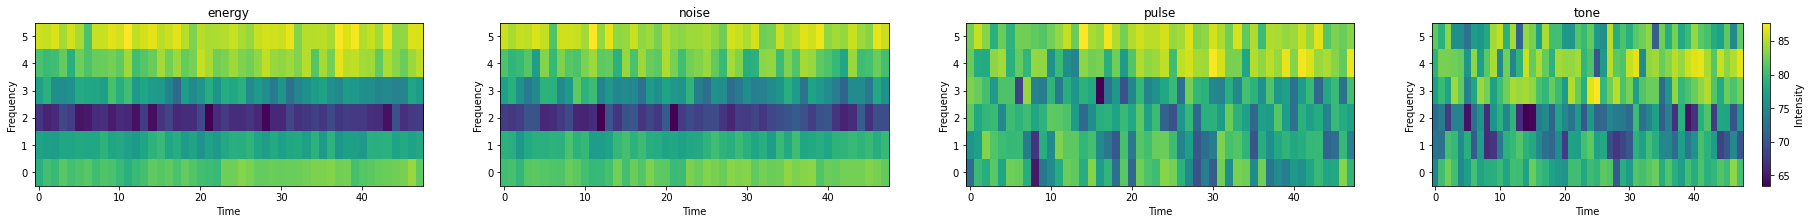

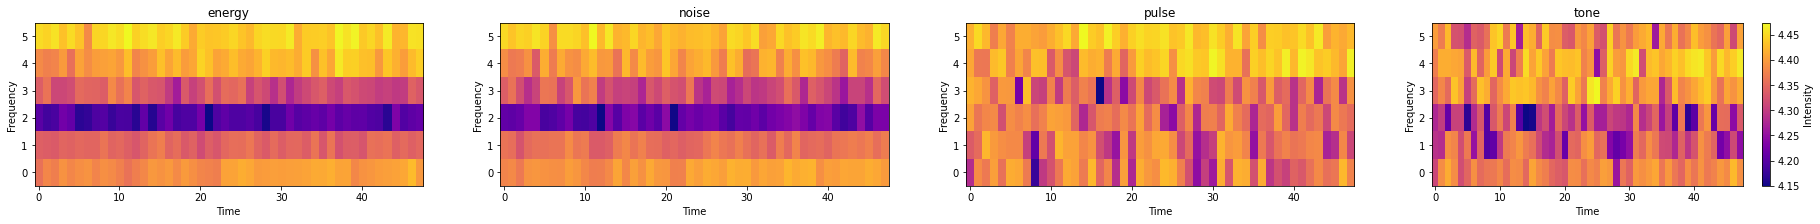

In [25]:
print("You are observing category:   %s" % categories[8])

category_4_label_hist(info_samples, categories[8])
print("")
category_4_labels(info_samples, categories[8])

## <div align="center">Conclusion</div>

Comparing with Tract data PTNE data seem like has less information.
What I am going to do next is that I will use algorithm that was tested on Tract data. I will avaluate the result and make a conclusion.